In [1]:
import torch
import numpy as np
import torch.distributions as D
import torch.nn as nn
import sklearn
import sklearn.datasets
import random

In [66]:
# seed
seed = 747 
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

def get_responsibilities(data, pis, mus, Sigmas, K):
    data_dim = data.size()[1]
    mus = mus.view(K, data_dim)
    Sigmas = Sigmas.view(K, data_dim, data_dim)
    pis = pis.view(-1)
    # create the constructor of multivariatenormal dist of the given paramters
    distns = D.MultivariateNormal(mus, Sigmas)
    # reshape the data, so it will produce three probabilities corresponding to three categories
    lps = distns.log_prob(data.view(-1,1,data_dim))
    logpis = torch.log(pis)
    temps = lps+logpis
    # log(pi * Norm) = log(pi) + log(norm)
    
    ziks = nn.Softmax(1)(temps)
    return ziks
    
    
def update_mu(ziks, data, mus, K):
    nks = ziks.sum(0)
    mus = []
    for k in range(K):
        mu_k = (ziks[:,k].view(-1,1)*data).sum(0)/nks[k]
        mus.append(mu_k)
    return torch.stack(mus, 0)

def update_Sigma(ziks,data,mus,Sigmas,K):
    nks = ziks.sum(0)
    Sigmas = []
    for k in range(K):
        demeaned = data - mus[k]
        Sigmas.append((demeaned.T@ torch.diag(ziks[:,k])@demeaned)/nks[k])
    return torch.stack(Sigmas,0)

def update_pi(ziks,data):
    nks = ziks.sum(0)
    return nks/data.size()[0]

In [67]:
means = torch.stack([-5*torch.ones(5), -1*torch.ones(5), 3*torch.ones(5)])
Sigmas = torch.stack([torch.tensor(sklearn.datasets.make_spd_matrix(5)),
                     torch.tensor(sklearn.datasets.make_spd_matrix(5)),
                     torch.tensor(sklearn.datasets.make_spd_matrix(5))])

means.double()
Sigmas.double()
mix = D.Categorical(torch.ones(3,))
comp = D.MultivariateNormal(means.double(), Sigmas)
gmm = D.MixtureSameFamily(mix, comp)
data = gmm.sample((100,))

In [68]:
def EM_GMM(data, mus_init, Sigmas_init, pi_init, K, n_iter=1000):
    mu = torch.clone(mus_init)
    Sigma = torch.clone(Sigmas_init)
    pi = torch.clone(pi_init)
    for i in range(n_iter):
        ziks = get_responsibilities(data, pi, mu, Sigma, K)
        mu = update_mu(ziks, data, mu, K)
        Sigma = update_Sigma(ziks, data, mu, Sigma, K)
        pi = update_pi(ziks, data)
    return pi, mu, Sigma

In [69]:
K = 3
pis = torch.tensor([.33, .34, .33]).double()
mus = torch.rand(3,5).double()
Sigmas = 5*torch.eye(5).view(1,5,5).repeat(3,1,1).double()
EM_GMM(data, mus, Sigmas, pis, K, 100)

(tensor([0.3300, 0.3400, 0.3300], dtype=torch.float64),
 tensor([[ 2.6393,  3.0998,  2.7830,  2.8629,  3.1710],
         [-0.9684, -0.9919, -1.0667, -1.1774, -1.1487],
         [-4.8103, -4.5495, -5.0647, -4.6336, -5.0160]], dtype=torch.float64),
 tensor([[[ 2.0672e+00,  4.0317e-01,  9.9368e-01, -1.2028e-02, -5.7615e-01],
          [ 4.0317e-01,  5.5658e-01,  2.3263e-01, -1.2983e-01, -1.6607e-01],
          [ 9.9368e-01,  2.3263e-01,  6.5973e-01,  6.9880e-02, -2.6689e-01],
          [-1.2028e-02, -1.2983e-01,  6.9880e-02,  3.7610e-01,  6.2561e-02],
          [-5.7615e-01, -1.6607e-01, -2.6689e-01,  6.2561e-02,  4.6020e-01]],
 
         [[ 8.1820e-01, -4.4257e-03,  5.1424e-02,  3.6330e-01, -3.6266e-01],
          [-4.4257e-03,  2.5359e-01, -2.2567e-01,  1.9635e-01,  1.1241e-01],
          [ 5.1424e-02, -2.2567e-01,  1.0345e+00, -1.8690e+00, -3.3147e-01],
          [ 3.6330e-01,  1.9635e-01, -1.8690e+00,  5.5159e+00,  6.0622e-01],
          [-3.6266e-01,  1.1241e-01, -3.3147e-01,  6.0622

In [70]:
from sklearn.mixture import GaussianMixture

sk_results = GaussianMixture(3).fit(data)
sk_results.weights_, sk_results.means_, sk_results.covariances_

(array([0.33, 0.33, 0.34]),
 array([[-4.81029226, -4.54950631, -5.06473239, -4.6336104 , -5.01602173],
        [ 2.63926413,  3.09981695,  2.78299456,  2.8629267 ,  3.17100632],
        [-0.96836634, -0.99190316, -1.06665851, -1.17739557, -1.14871311]]),
 array([[[ 1.46972774e+00,  1.40004272e+00, -3.39937067e-01,
           5.35237014e-02, -4.32455383e-01],
         [ 1.40004272e+00,  2.35618258e+00, -8.21323510e-01,
           6.95082620e-02, -3.91599967e-01],
         [-3.39937067e-01, -8.21323510e-01,  4.49257169e-01,
          -4.09316169e-02,  5.76191551e-02],
         [ 5.35237014e-02,  6.95082620e-02, -4.09316169e-02,
           2.04297620e-01,  3.49784300e-02],
         [-4.32455383e-01, -3.91599967e-01,  5.76191551e-02,
           3.49784300e-02,  4.40244144e-01]],
 
        [[ 2.06715445e+00,  4.03165812e-01,  9.93683414e-01,
          -1.20284455e-02, -5.76145028e-01],
         [ 4.03165812e-01,  5.56581978e-01,  2.32633819e-01,
          -1.29825319e-01, -1.66069740e-01],


In [27]:
distns = D.MultivariateNormal(mus,Sigmas)


In [30]:
logpis = torch.log(pis)
logpis

tensor([-1.1087, -1.0788, -1.1087], dtype=torch.float64)

In [32]:
lps = distns.log_prob(data.view(-1,1,5))

In [35]:
?distns.log_prob

Signature: distns.log_prob(value)
Docstring:
Returns the log of the probability density/mass function evaluated at
`value`.

Args:
    value (Tensor):
File:      d:\conda\lib\site-packages\torch\distributions\multivariate_normal.py
Type:      method


In [36]:
data.view(-1,1,5).size()

torch.Size([100, 1, 5])

In [37]:
lps.size()

torch.Size([100, 3])

In [38]:
logpis.size()

torch.Size([3])

In [39]:
temp = lps + logpis
temp.size()

torch.Size([100, 3])

In [43]:
ziks = nn.Softmax(1)(temp)
ziks.size()

torch.Size([100, 3])

In [44]:
nks = ziks.sum(0)
nks

tensor([28.4921, 29.4939, 42.0140], dtype=torch.float64)

In [48]:
ss = ziks[:,0].view(-1,1)*data

In [51]:
mu_k = ss.sum(0)/nks[0]

In [53]:
mus.size()

torch.Size([3, 5])

In [54]:
demeaned = data- mus[0]
sig = demeaned.T @ torch.diag(ziks[:,0]) @ demeaned / nks[0]

In [55]:
sig

tensor([[12.4411, 10.5048, 11.5102, 10.8878, 11.1587],
        [10.5048, 11.6696, 10.7590, 10.9930,  9.7110],
        [11.5102, 10.7590, 11.8610, 10.9593, 10.1952],
        [10.8878, 10.9930, 10.9593, 11.5004,  9.7731],
        [11.1587,  9.7110, 10.1952,  9.7731, 13.5046]], dtype=torch.float64)

Real Data

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
X,Y = load_iris(return_X_y = True, as_frame = True)
pd.concat([X,pd.DataFrame(Y)], axis = 1)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


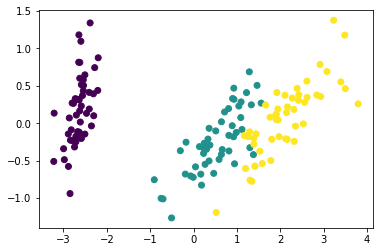

In [73]:
from sklearn.decomposition import PCA
xy = PCA(2).fit_transform(X.values)
colors = Y.values
plt.scatter(xy[:,0],xy[:,1],c = colors)
plt.show()

In [82]:
def plot_iris(data, responsibilities):
    xy = PCA(2).fit_transform(data)
    colors = np.argmax(responsibilities.numpy(), 1)
    plt.scatter(xy[:,0], xy[:,1], c=colors)
    plt.show()
    

def EM_GMM_progress(data, mus_init, Sigmas_init, pi_init, K, n_iter=1000, every=100):
    mu = torch.clone(mus_init)
    Sigma = torch.clone(Sigmas_init)
    pi = torch.clone(pi_init)
    for i in range(n_iter):
        ziks = get_responsibilities(data, pi, mu, Sigma, K)
        mu = update_mu(ziks, data, mu, K)
        Sigma = update_Sigma(ziks, data, mu, Sigma, K)
        pi = update_pi(ziks, data)
        
        if i % every == 0:
            plot_iris(data, ziks)
    return pi, mu, Sigma

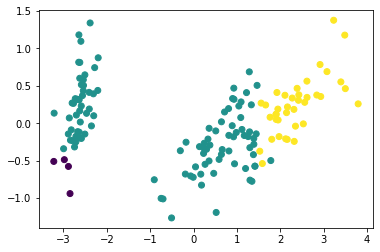

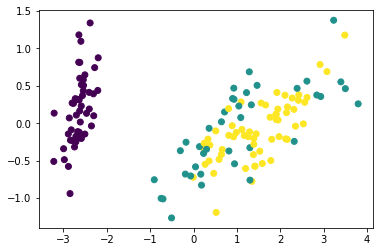

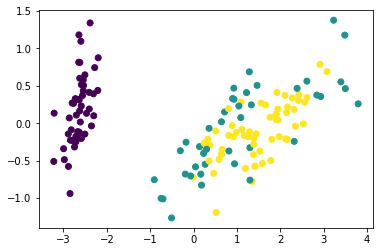

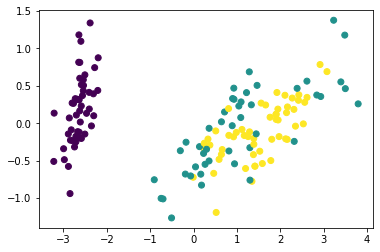

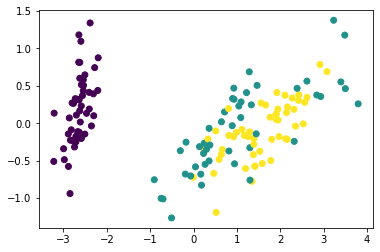

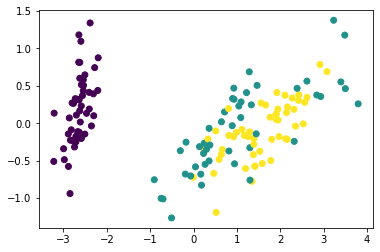

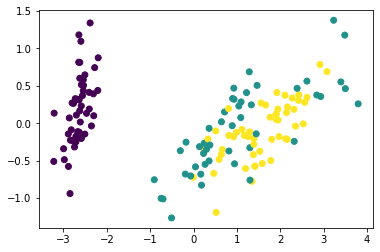

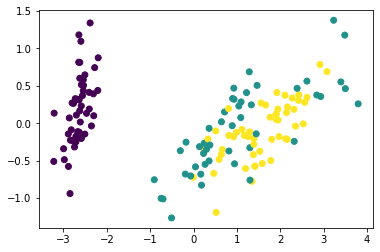

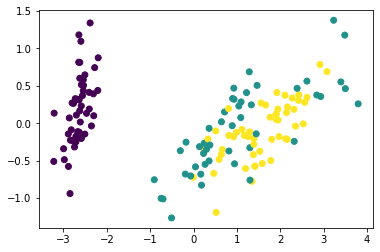

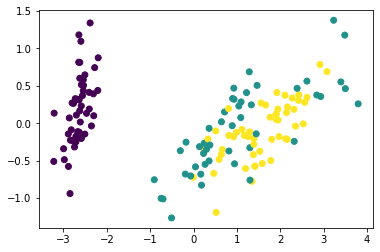

(tensor([0.3332, 0.3125, 0.3543], dtype=torch.float64),
 tensor([[5.0062, 3.4285, 1.4621, 0.2460],
         [6.2947, 2.7781, 4.6800, 1.4490],
         [6.2325, 2.9546, 5.1039, 1.8757]], dtype=torch.float64),
 tensor([[[0.1217, 0.0970, 0.0160, 0.0101],
          [0.0970, 0.1403, 0.0114, 0.0091],
          [0.0160, 0.0114, 0.0296, 0.0060],
          [0.0101, 0.0091, 0.0060, 0.0109]],
 
         [[0.6152, 0.1857, 0.7241, 0.2252],
          [0.1857, 0.1438, 0.1907, 0.0699],
          [0.7241, 0.1907, 1.0013, 0.3140],
          [0.2252, 0.0699, 0.3140, 0.1088]],
 
         [[0.2752, 0.0693, 0.2207, 0.1262],
          [0.0693, 0.0650, 0.0635, 0.0525],
          [0.2207, 0.0635, 0.3075, 0.1780],
          [0.1262, 0.0525, 0.1780, 0.1555]]], dtype=torch.float64))

In [85]:
K = 3
pis = torch.tensor([.33, .34, .33]).double()
mus = torch.rand(3,4).double() + 2.5
Sigmas = torch.eye(4).view(1,4,4).repeat(3,1,1).double()

EM_GMM_progress(torch.tensor(X.values), mus, Sigmas, pis, K, 100, 10)

In [3]:
help(D. multinomial)

Help on module torch.distributions.multinomial in torch.distributions:

NAME
    torch.distributions.multinomial

CLASSES
    torch.distributions.distribution.Distribution(builtins.object)
        Multinomial
    
    class Multinomial(torch.distributions.distribution.Distribution)
     |  Multinomial(total_count=1, probs=None, logits=None, validate_args=None)
     |  
     |  Creates a Multinomial distribution parameterized by :attr:`total_count` and
     |  either :attr:`probs` or :attr:`logits` (but not both). The innermost dimension of
     |  :attr:`probs` indexes over categories. All other dimensions index over batches.
     |  
     |  Note that :attr:`total_count` need not be specified if only :meth:`log_prob` is
     |  called (see example below)
     |  
     |  .. note:: The `probs` argument must be non-negative, finite and have a non-zero sum,
     |            and it will be normalized to sum to 1 along the last dimension. :attr:`probs`
     |            will return this n

In [14]:
# seed
seed = 747 
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

def get_responsibilities_lca(data, pis, mus,K):
    data_dim = data.size()[1]
    mus = mus.view(K, data_dim)
    pis = pis.view(-1)
    # create the constructor of multivariatenormal dist of the given paramters
    distns = D.Bernoulli(mus)
    # reshape the data, so it will produce three probabilities corresponding to three categories
    lps = distns.log_prob(data.view(-1,1,data_dim)).sum(-1)
    # return n*K
    logpis = torch.log(pis)
    temps = lps+logpis
    # 1*K + n*K = n*K
    # log(pi * Norm) = log(pi) + log(norm)
    
    ziks = nn.Softmax(1)(temps)
    
    # n*k
    return ziks
    
    
def update_mu_lca(ziks, data, mus, K):
    # n*k --> k
    nks = ziks.sum(0)
    mus = []
    for k in range(K):
        # n*1 \times n*D --> n*D
        # n*D --> D
        mu_k = (ziks[:,k].view(-1,1)*data).sum(0)/nks[k]
        mus.append(mu_k)
    return torch.stack(mus, 0)

def update_pi_lca(ziks,data):
    # n*k --> k
    nks = ziks.sum(0)
    # k
    return nks/data.size()[0]

In [15]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import math
np.random.seed(8)
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X = torch.where(torch.tensor(X) != 0., 1., 0.)

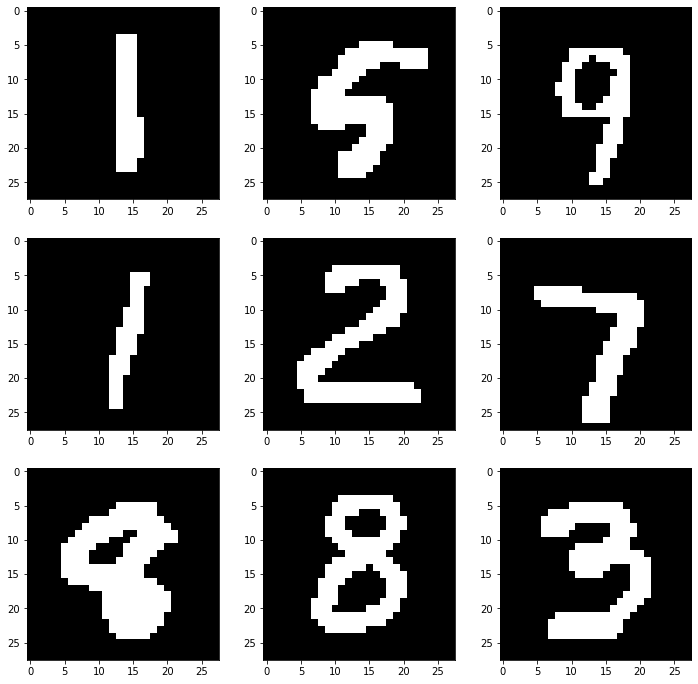

In [16]:
num_images = 9
width = int(math.sqrt(num_images))
fig, axs = plt.subplots(width, width, figsize=(12, 12))

for i, j in zip(np.random.randint(0, X.size()[0], num_images), np.arange(0,num_images)):
    r = j // width
    c = j % width
    ax = axs[r][c]
    ax.imshow(X[i].numpy().reshape(28,28), cmap='gray')
plt.show()

In [17]:
def LCA_EM(data,pis,mus,K,n_iter = 100):
    mu = torch.clone(mus)
    pi = torch.clone(pis)
    for i in range(n_iter):
        ziks = get_responsibilities_lca(data,pi,mu,K)
        mu = update_mu_lca(ziks,data,mu,K)
        pi = update_pi_lca(ziks,data)
    return pi,mu

def show_means(means):
    num_images = 10
    fig,axs = plt.subplots(2,5)
    plt.subplots_adjust(wspace = 0,hspace = 0)
    for i,j in zip(np.arange(0,num_images), np.arange(0,num_images)):
        r = j//5
        c = j% 5
        ax = axs[r][c]
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.imshow(means[i].numpy().reshape(28,28), cmap = 'gray')
        
    plt.show()
    
def LCA_EM_progress(data, pis, mus, K, n_iter=100, every=10):
    mu = torch.clone(mus)
    pi = torch.clone(pis)
    for i in range(n_iter):
        if i % every == 0:
            print('ITERATION {}'.format(i))
            show_means(mu)
            
        ziks = get_responsibilities_lca(data, pi, mu, K)
        mu = update_mu_lca(ziks, data, mu, K)
        pi = update_pi_lca(ziks, data)
    return pi, mu

ITERATION 0


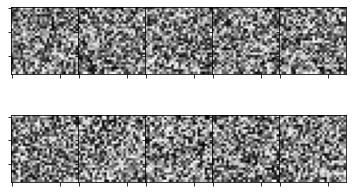

ITERATION 1


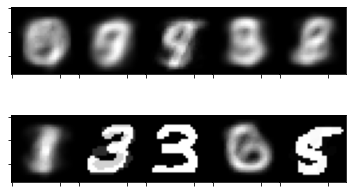

ITERATION 2


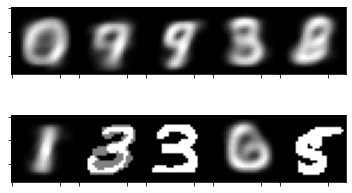

ITERATION 3


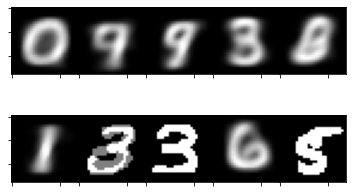

ITERATION 4


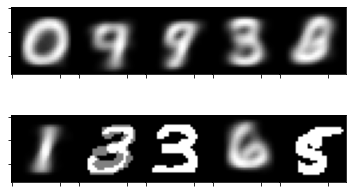

ITERATION 5


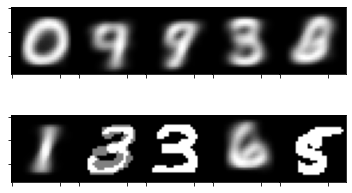

ITERATION 6


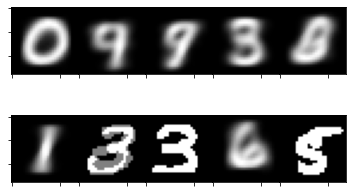

ITERATION 7


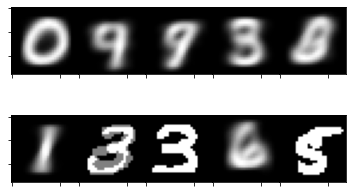

ITERATION 8


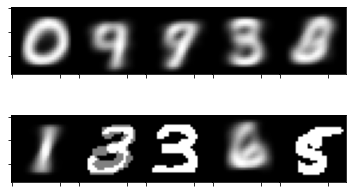

ITERATION 9


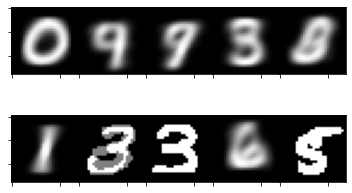

In [18]:
K = 10
pis = torch.arange(1,K+1)/torch.sum(torch.arange(1,K+1))
mus = torch.rand(K, 784)
data = X[torch.randperm(X.size()[0])][:10000]
results = LCA_EM_progress(data, pis, mus, 10, 10, 1)    

# FA AND PPCA EM

In [142]:
def expct_f(L,phi,X):
    X = X.view(-1,1)
    k = L.size()[1]
    #exp = L.T @ torch.linalg.inv(L@L.T + phi) @ X
    exp = torch.linalg.inv(torch.eye(k)+ L.T@torch.linalg.inv(phi)@L)@L.T@torch.linalg.inv(phi)@X
    return exp

def expct_f_ft(L,phi,X):
    k = L.size()[1]
    p = L.size()[0]
    X = X.view(-1,1)
    # beta = L.T @ torch.linalg.inv(L@L.T + phi)
    var = torch.linalg.inv(torch.eye(k)+ L.T@torch.linalg.inv(phi)@L)
    e = expct_f(L,phi,X)
    ll = var + e@e.T
    return ll

def update_L(L,phi,data):
    n = data.size()[0]
    p = data.size()[1]
    ef = torch.stack([m.view(-1,1)@expct_f(L,phi,m).T for m in torch.unbind(data, dim = 0)],dim =0).sum(0)
    eff = torch.stack([expct_f_ft(L,phi,m) for m in torch.unbind(data,dim = 0)], dim = 0).sum(0)
    L_new = ef@torch.linalg.inv(eff)
    return L_new
    
def update_phi(L,phi,data):
    n = data.size()[0]
    p = data.size()[1]
    S = torch.cov(data.T, correction = 0)
    eff = torch.stack([expct_f_ft(L,phi,m) for m in torch.unbind(data,dim = 0)], dim = 0).sum(0)
    phi = S - L @ eff@L.T/n
    return torch.diag(torch.diag(phi))

In [143]:
def EM_FA(data, L_init,phi_init,K,n_iter = 100):
    L = torch.clone(L_init)
    phi = torch.clone(phi_init)
    for i in range(n_iter):
        L = update_L(L,phi,data)
        phi = update_phi(L,phi,data)
    return L,phi

In [144]:
N =100
p =2
q = 7
Lambda = np.array([[1] * 4 + [0] * 3, [0] * 3 + [1] * 4]).T
sigma2 = 0.4
Psi = sigma2 * np.ones(q)
np.random.seed(0)
X =np.random.normal(0.,1.,(N,p))
W = np.random.normal(0., np.sqrt(sigma2),(N,q))

Y = X@Lambda.T + W

In [145]:
data = torch.from_numpy(Y).double()
data = data -data.mean(0)

In [146]:
K = 2 
phi = torch.eye(7).double()
L = torch.rand(7,2).double()


In [147]:
X = torch.unbind(data,dim = 0)[0]

In [148]:
EM_FA(data,L,phi,2,100)

(tensor([[ 0.0111,  1.0607],
         [ 0.0550,  1.0874],
         [ 0.0049,  0.9642],
         [ 1.0131,  1.0736],
         [ 0.9808, -0.0187],
         [ 1.0279,  0.0487],
         [ 0.9398, -0.0476]], dtype=torch.float64),
 tensor([[0.2154, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.4847, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.5212, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.3617, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.3389, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4911, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4260]],
        dtype=torch.float64))